## 下载数据

In [35]:
import os
import sys
import tarfile
import urllib

from attr import attributes

sys.setdefautencoding = 'utf-8'
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path, encoding='utf-8')
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()


## 加载数据

In [36]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [37]:
## 通过info函数可以查看数据是否含有缺失值以及数据类型以便后续处理
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [38]:
# 观察到ocean_proximity这一行的类型是对象 现在查看是否是分类数据
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [39]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


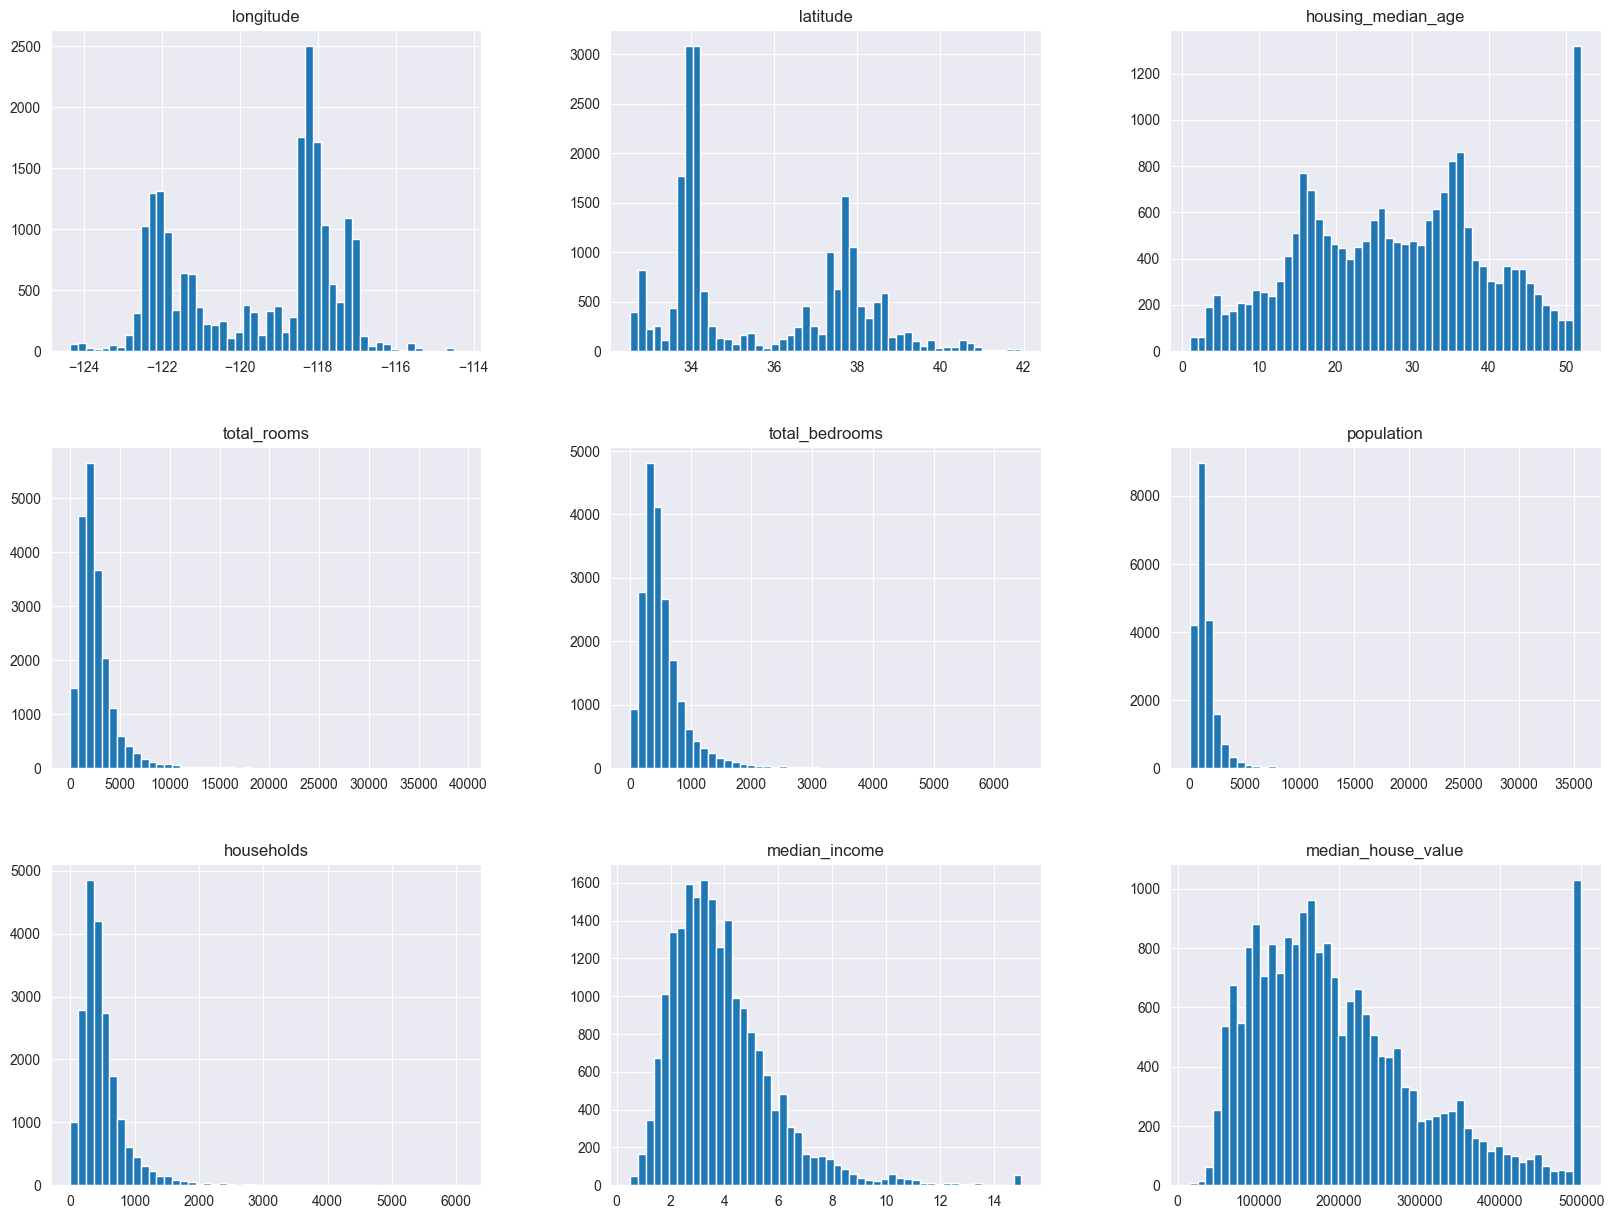

In [40]:
# 使用直方图查看数据分布特征
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize= (20, 15))
plt.show()

## 划分数据集


In [41]:
import numpy as np

def split_train_test(data, test_ratio):
    # 将数据集索引打乱 以便后续进行划分
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [42]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


## 以上两种方法在下一次获取更新的数据的时候都会中断 为了即使在更新数据后仍然有一个稳定的训练分割 常见的解决方案是个实例添加标识符 计算实例标识符的哈希值 这样确保测试集在多个运行里是一致的 及时更新数据也会一致

In [43]:
from zlib import crc32 # crc32这个用来检测数据是否被修改过
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# 由于housing数据集没有id列 所以添加index使用行作为id
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

# 如果使用行作为id 则要注意添加数据的时候必须添加在数据集的末尾 并且不会删除任何行 否则只能在最稳定的行作为标识符 在这个数据集则是经纬度
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

# scikit-learn库提供了train_test_split函数 可以很方便的划分数据集

In [44]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size= 0.2, random_state= 42)

# 房价的中位数与收入的中位数有关 但是我们希望测试集可以代表所有的层次 所以我们想要进行分层抽样
## 也就是说我们不能将层数分的太多 每一层要足够大

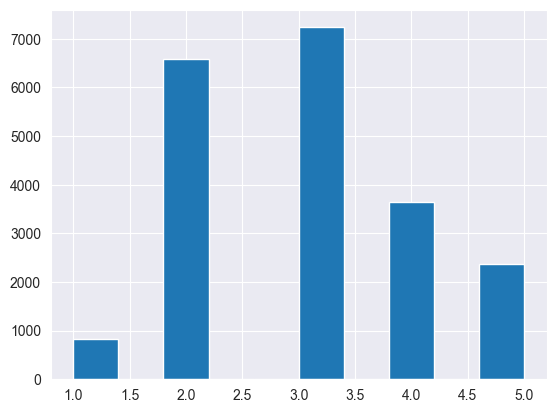

In [45]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.show()

# 现在根据收入类别进行分层抽样

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    start_train_set = housing.iloc[train_index]
    start_test_set = housing.iloc[test_index]

start_train_set['income_cat'].value_counts() / len(start_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [47]:
for i in (start_train_set, start_test_set):
    i.drop('income_cat', axis=1, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_60460\2157417856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop('income_cat', axis=1, inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_60460\2157417856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i.drop('income_cat', axis=1, inplace=True)


# 下面开始进行数据探索

In [48]:
housing = start_train_set.copy()

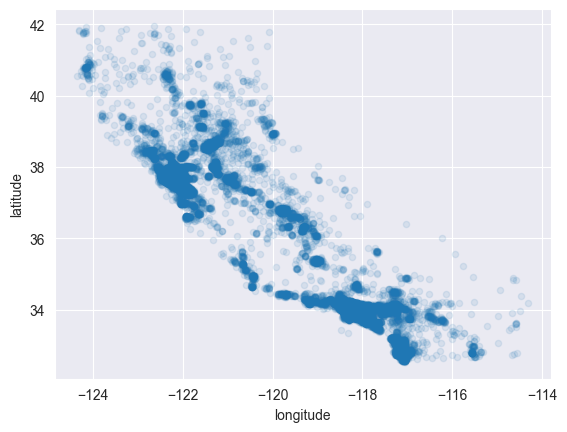

In [49]:
housing.plot(kind='scatter', x='longitude', y='latitude',alpha= 0.1) #alpha参数用于设置点的透明度，取值范围是0到1。值越小，点越透明；值越大，点越不透明。在散点图中设置较低的alpha（如0.1），可以让点重叠的区域更明显，便于观察数据的密集分布
plt.show()

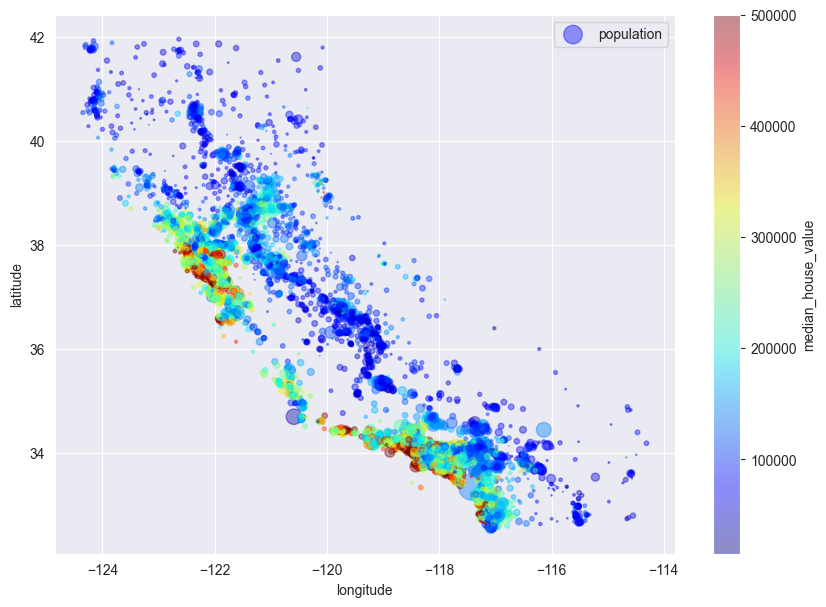

In [50]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap='jet', colorbar=True)
plt.legend()
plt.show()

# 寻找数据之间的相关性

In [51]:
housing_num = housing.drop('ocean_proximity', axis=1)
corr_matrix = housing_num.corr()

In [52]:
# 注意 相关系数只能显示线性关系 非线性关系显示不出来
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

# 使用pandas的scatter_matrix函数可以同时绘制出所有变量两两之间的相关系数

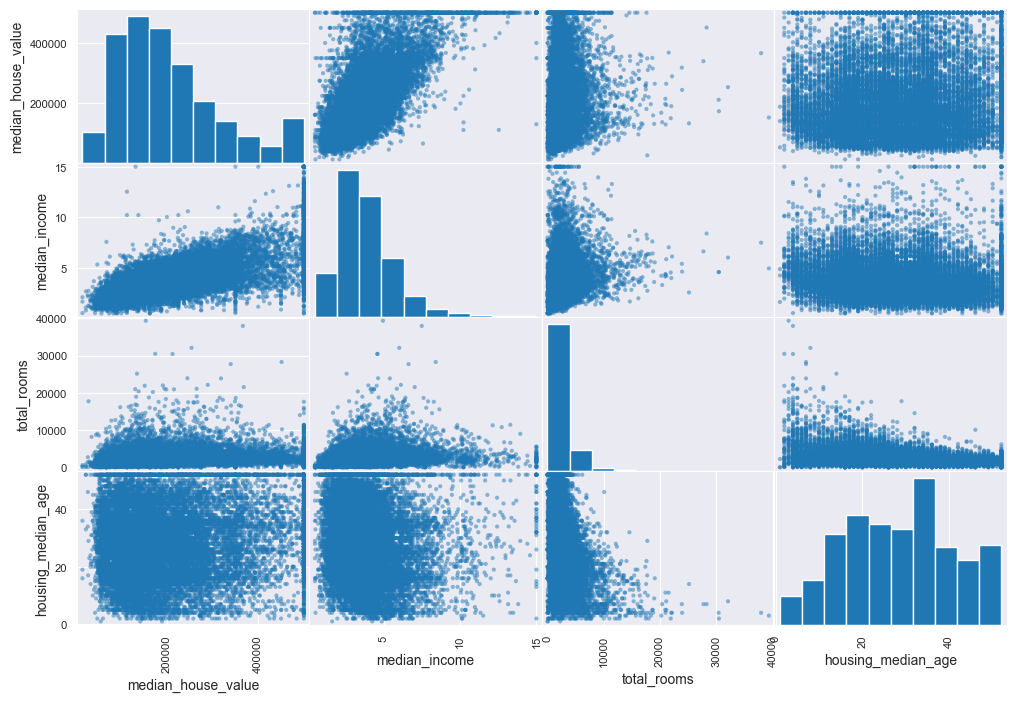

In [53]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

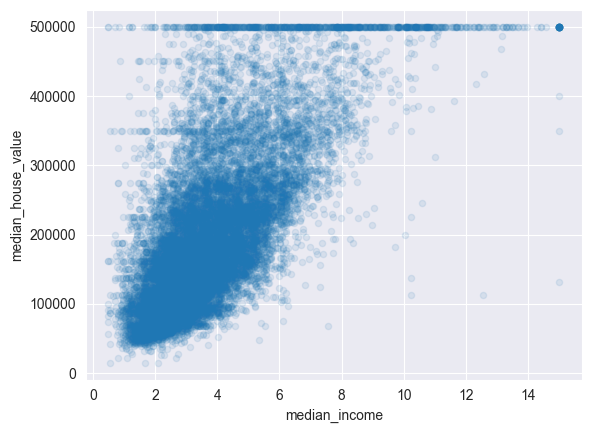

In [54]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

 # 尝试不同类型数据的总和

In [55]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']
housing_num = housing.drop('ocean_proximity', axis=1)
corr_matrix = housing_num.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# 机器学习算法的准备

In [56]:
housing = start_train_set.drop('median_house_value', axis=1)
housing_labels = start_train_set['median_house_value'].copy()

In [57]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_60460\530063441.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['total_bedrooms'].fillna(median, inplace=True)


In [58]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [59]:
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [60]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)

In [61]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [62]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [63]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(housing_cat_1hot)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>
  Coords	Values
  (0, 1)	1.0
  (1, 4)	1.0
  (2, 1)	1.0
  (3, 4)	1.0
  (4, 0)	1.0
  (5, 3)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 1)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 3)	1.0
  (19, 0)	1.0
  (20, 1)	1.0
  (21, 3)	1.0
  (22, 1)	1.0
  (23, 0)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 0)	1.0
  (16489, 4)	1.0
  (16490, 4)	1.0
  (16491, 1)	1.0
  (16492, 1)	1.0
  (16493, 0)	1.0
  (16494, 0)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 0)	1.0
  (16498, 4)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 1)	1.0
  (16502, 1)	1.0
  (16503, 1)	1.0
  (16504, 1)	1.0
  (16505, 0)	1.0
  (16506, 0)	1.0
  (16507, 0)	1.0
  (16508, 1)	1.0
  (16509, 0)	1.0
  (16510, 0)	1.0
  (16511, 1)	1.0


In [64]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## 自定义转化器

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# 特征缩放
## 标准化 StandardScaler
## 归一化 MinMaxScaler

# 转化流水线 Pipeline

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # 中位数填补缺失值
    ('attribs_adder', CombinedAttributesAdder()), # 添加新特征
    ('std_scaler', StandardScaler()), # 标准化特征
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

## 处理所有列的转化器

In [68]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# 选择和训练模型

In [70]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [71]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

# 使用决策时来进行模型改良

In [72]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# 使用交叉验证来进行模型改良

### 使用k折交叉验证

In [73]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72251.22610062 70811.34799853 68000.08591434 71929.39104752
 69328.61392367 77963.99482744 71628.79228943 73511.78648072
 69045.58722762 69854.4073967 ]
Mean: 71432.52332065887
Standard deviation: 2696.6824522410743


In [74]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818065


In [75]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18733.78842762556

In [77]:
import joblib
joblib.dump(forest_reg, 'my_model\my_model.pkl')

['my_model\\my_model.pkl']

# 微调模型

In [1]:
from sklearn.model_selection import GridSearchCV
# 当超参数不知道赋什么值的时候可以考虑10的幂次方
# bootstrap = False表示不是用默认的超参数
param_grid = [{
    'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
grid_search.best_params_

grid_search.best_estimators_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

## 随机搜索 RandomizedSearchCV
### 这个方法在超参数比较多的时候好用 因为随机搜索会评估每一个随机组合

# 分析最佳模型以及误差

In [ ]:
feature_importances = grid_search.best_estimators_.best_estimator_.feature_importances_
feature_importances


# 查看那些特征对模型是有用的

In [ ]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

# 通过测试集评估model

In [ ]:
final_model = grid_search.best_estimators_.best_estimator_

x_test = start_test_set.drop(['median_house_value'], axis= 1)
y_test = start_test_set['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# 计算置信区间

In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

# 流程监控
## 通常情况先需要监控模型 还要保证模型的时效性 因为数据在不停变化 比如手机镜头的相机
## 要保证model不要腐烂 即随着时间的推演渐渐变得无效甚至副作用 比如商品推荐
## 每当新数据进来的时候都要重新训练模型 以及人工监控模型
## 最好将以上流程自动化